In [444]:
import os

random_state = 123

Всего файлов в папке "sampled_texts":

In [445]:
len(os.listdir('sampled_texts'))

200

In [446]:
documents = []

for file in os.listdir('sampled_texts'):
    if file.endswith('.txt'):
        with open('sampled_texts/' + file, 'r') as f:
            text = f.read()
            documents.append(text)
            
documents[:3]

['Topic: Ottawa Says Time to Stop Protecting Air Canada\n\nText: The Canadian government, in a radical shift, said on Friday it was time to stop protecting national carrier Air Canada as it mulled whether to lift foreign ownership restrictions on the country #39;s airlines.',
 'Topic: Wall Street Faces 2 Elections, Not Just 1 (Reuters)\n\nText: Reuters - The waiting game for the U.S.\\presidential election ends two weeks from Tuesday -- but then\\investors can turn over the timer and start again.',
 'Topic: White House Rejects Trade Case Vs. China (AP)\n\nText: AP - The Bush administration on Friday rejected a request from 30 members of Congress that it bring a World Trade Organization case against China charging the Asian nation with manipulating its currency to gain unfair trade advantages against the United States.']

Удалим заголовки из текстов ("Topic:" и "Text:"):

In [447]:
def delete_headers(text):
    headers = ("Topic:", "Text:")
    lines = text.split('\n')
    for i, line in enumerate(lines):
        for header in headers:
            if line.startswith(header):
                line = line[len(header):]
                lines[i] = line
                break
    return '\n'.join(lines)

documents = [delete_headers(doc) for doc in documents]
documents[:3]

[' Ottawa Says Time to Stop Protecting Air Canada\n\n The Canadian government, in a radical shift, said on Friday it was time to stop protecting national carrier Air Canada as it mulled whether to lift foreign ownership restrictions on the country #39;s airlines.',
 ' Wall Street Faces 2 Elections, Not Just 1 (Reuters)\n\n Reuters - The waiting game for the U.S.\\presidential election ends two weeks from Tuesday -- but then\\investors can turn over the timer and start again.',
 ' White House Rejects Trade Case Vs. China (AP)\n\n AP - The Bush administration on Friday rejected a request from 30 members of Congress that it bring a World Trade Organization case against China charging the Asian nation with manipulating its currency to gain unfair trade advantages against the United States.']

In [448]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bred7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bred7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bred7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Предобработаем тексты (приведем к нижнему регистру, удалим знаки препинания и стоп-слова, лемматизируем):

In [449]:
import re

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text):
    text = text.lower()
    text = clean_text(text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

preprocessed_docs = [preprocess(doc) for doc in documents]

Получим векторные представления текстов с помощью SentenceTransformer:

In [450]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(preprocessed_docs)
embeddings.shape

(200, 384)

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packag

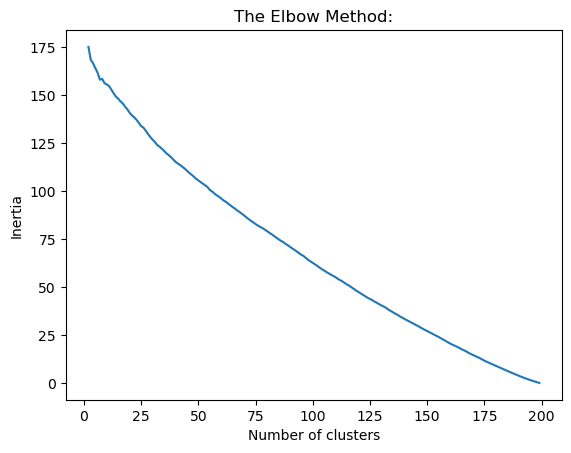

In [451]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

max_clusters = 200
k_range = range(2, max_clusters)

inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method:')
plt.show()

Попробуем другой метод оценки оптимального количества кластеров - Silhouette Score:

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packag

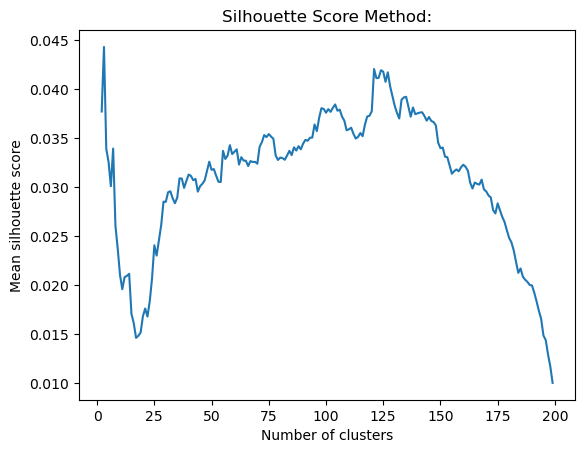

In [452]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Mean silhouette score')
plt.title('Silhouette Score Method:')
plt.show()

In [453]:
import numpy as np
k = np.argmax(silhouette_scores) + 2 # так как начинали с 2 кластеров
k

3

Метод локтя не показал наличие четкого "локтя" на графике, Silhouette Score показал, что оптимальное количество кластеров - 3.

In [454]:
kmeans = KMeans(n_clusters=k, random_state=random_state)
cluster_labels = kmeans.fit_predict(embeddings)

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [455]:
import pandas as pd

df = pd.DataFrame({'text': documents, 'cluster': cluster_labels})
df.to_csv('KMeans_clusters.csv', index=False)

In [460]:
df["text"][df["cluster"] == 0]

6                 Learning to Search for Life on Mars with the Atacama Rover\n\n Ames Research Center -- A dedicated team of scientists is spending the next four weeks in northern Chile's Atacama Desert. They are studying the scarce life that exists there and, in the process, helping NASA learn more about how primitive life forms could exist on Mars...
8                                                                                                                                                                                                BBC reporters' log\n\n BBC correspondents record events in the Middle East and their thoughts as the funeral of the Palestinian leader Yasser Arafat takes place.
13                                                                                                                                                                                                                         Rebels return to 'cleared' areas\n\n In Fallujah, US forces are going t

In [461]:
df["text"][df["cluster"] == 1]

7                                                                                                                                         Spotlight shines on quarterbacks\n\n They couldn't be more different. One is the prototype quarterback, seemingly built using the create-a-player function from a video game, standing tall in the pocket and firing laser beams across the field.
11                                                                                                                                                                                          Yankees Seek to Keep Pitcher Jon Lieber (AP)\n\n AP - After watching their starting pitchers struggle for much of the season, the New York Yankees would like to bring Jon Lieber back for 2005.
12                                                                                                                                                       Nebraska holds on for victory\n\n Nebraska capitalized on four Pittsburgh turnovers a

In [462]:
df["text"][df["cluster"] == 2]

0                                                                                      Ottawa Says Time to Stop Protecting Air Canada\n\n The Canadian government, in a radical shift, said on Friday it was time to stop protecting national carrier Air Canada as it mulled whether to lift foreign ownership restrictions on the country #39;s airlines.
1                                                                                                                                          Wall Street Faces 2 Elections, Not Just 1 (Reuters)\n\n Reuters - The waiting game for the U.S.\presidential election ends two weeks from Tuesday -- but then\investors can turn over the timer and start again.
2                                   White House Rejects Trade Case Vs. China (AP)\n\n AP - The Bush administration on Friday rejected a request from 30 members of Congress that it bring a World Trade Organization case against China charging the Asian nation with manipulating its currency to gain unfair 

Можно заметить, что в первый кластер выделились более жёсткие новости (похороны Палестинского лидера, война в Ираке, побег в страхе ареста правительством, смерти от катаклизмов в Китае, раненый бразильский солдат, что-то про суд над ветераном, Пакистан, взрывы машин в Багдаде с погибшими, похищения людей, джихад, падения вертолёта, глобальное потепление, авария на космической станции, смерть Колумбийского офицера, Итальянские солдаты в Ираке, подкрепление войск в Афганистане, бунты в Чечне, похищения, ураган, Палестина, и так далее)

Во второй кластер попали спортивные новости (баскетбол, выигрыш приза космической командой, футбол, перемены в командах, янки-твинс, ошибки и травмы игроков, плаванье, плэй-оффы, бейсбол, гонки, что-то про футбольных фанатов, игры ravens, falcons и так далее)

В третий кластер попали экономические и финансовые новости (мировые корпорации, падение акций, профит компаний, приобретение банка в США, конфиденциальность на eBay, Samsung, Amazon, Nvidia, Solaris, Microsoft, Sun и их отношения, борьба кинокомпаний с пиратством, цены на нефть, Юкос, курс доллара, Азиатская телеком компания, новые полупроводники, водафон, презентации крупных игровых компаний (Nintendo, Sony), битва Intel и AMD в мире процессоров, новые технологии компании HP, Nokia и так далее)

In [465]:
# теперь попробуем кластеризовать новые тексты (первые 2 про войну в Украине, вторые 2 про футбол и баскетбол, третьи 2 про Ubisoft и Sony):
new_texts = [
    "Russia continues to pound Ukraine with air strikes targeting crucial energy facilities and critical sides now the Russian forces have claimed a series of air strikes targeting Ukrainian energy facilities over the past week",
    "Ukrainian journalist held in Russian captivity for more than a year was confirmed dead, authorities announced this week.",
    "Michigan football: Snap counts for every true freshman in 2024, one has burned redshirt",
    "The Naismith Hall of Fame will enshrine the Class of 2024 this weekend, with 13 inductees earning their orange jackets in Springfield, Massachusetts.",
    "Ubisoft Responds to Sale Rumors: ‘Star Wars Outlaws' Publisher ‘Regularly Reviews All Its Strategic Options",
    "On the eve of the PS5 Pro's $700 release, Sony is selling refurbished PlayStation 5 models from its 2020 lineup with a sizable $50 discount on both models."
]

new_texts = [preprocess(text) for text in new_texts]
new_embeddings = model.encode(new_texts)
new_cluster_labels = kmeans.predict(new_embeddings)
new_cluster_labels

array([0, 0, 1, 1, 2, 2])

Как видно, новые тексты были кластеризованы в соответствии с их содержанием.